In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from glob import glob
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    
    return tf.argmax(tf.cast(one_hot, tf.int32))

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_TL(file_path):
    label = get_label(file_path)
    print(label)
    img = tf.io.read_file(file_path)

    img = decode_img(img)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

Num GPUs Available:  1


In [2]:
img_height = 224
img_width = 224

epoch = 5
batch_size = 32

base_dir = r'C:\Users\Szymon\101_split'
train_dir = base_dir + '\\train'
val_dir = base_dir + '\\val'

train_files = tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=False)
val_files = tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False)

train_num_files=len([file for file in glob(str(train_dir + '\\*\\*'))])
val_num_files=len([file for file in glob(str(val_dir + '\\*\\*'))])
print(train_num_files)
print(val_num_files)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_dir)]))
num_classes = len(class_names)

train_dataset = train_files.interleave(lambda x: tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=True), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_files.interleave(lambda x: tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)

5724
821
Tensor("ArgMax:0", shape=(), dtype=int64)
Tensor("ArgMax:0", shape=(), dtype=int64)


In [3]:
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    ])

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    weights='imagenet',
    include_top=False)

base_model.trainable = False

filepath = 'cnn_model.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min')

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 97)                124257    
Total params: 4,173,828
Trainable params: 124,257
Non-trainable params: 4,049,571
_________________________________________________________________


In [4]:
train_dataset = train_dataset.repeat().shuffle(buffer_size=32).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

start_time= time.perf_counter()
model_train = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch,
    callbacks = [checkpoint]
)

print(time.perf_counter()-start_time)

Epoch 1/5
178/178 [==============================] - 55s 245ms/step - loss: 1.7948 - accuracy: 0.6859 - val_loss: 0.6847 - val_accuracy: 0.8650

Epoch 00001: val_loss improved from inf to 0.68471, saving model to cnn_model.hdf5


D:\Programy\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
178/178 [==============================] - 41s 232ms/step - loss: 0.4532 - accuracy: 0.9252 - val_loss: 0.3915 - val_accuracy: 0.9150

Epoch 00002: val_loss improved from 0.68471 to 0.39153, saving model to cnn_model.hdf5
Epoch 3/5
178/178 [==============================] - 42s 238ms/step - loss: 0.2766 - accuracy: 0.9477 - val_loss: 0.3145 - val_accuracy: 0.9200

Epoch 00003: val_loss improved from 0.39153 to 0.31454, saving model to cnn_model.hdf5
Epoch 4/5
178/178 [==============================] - 42s 235ms/step - loss: 0.1895 - accuracy: 0.9649 - val_loss: 0.2791 - val_accuracy: 0.9200

Epoch 00004: val_loss improved from 0.31454 to 0.27913, saving model to cnn_model.hdf5
Epoch 5/5
178/178 [==============================] - 43s 239ms/step - loss: 0.1430 - accuracy: 0.9731 - val_loss: 0.2594 - val_accuracy: 0.9300

Epoch 00005: val_loss improved from 0.27913 to 0.25943, saving model to cnn_model.hdf5
226.22698380000003


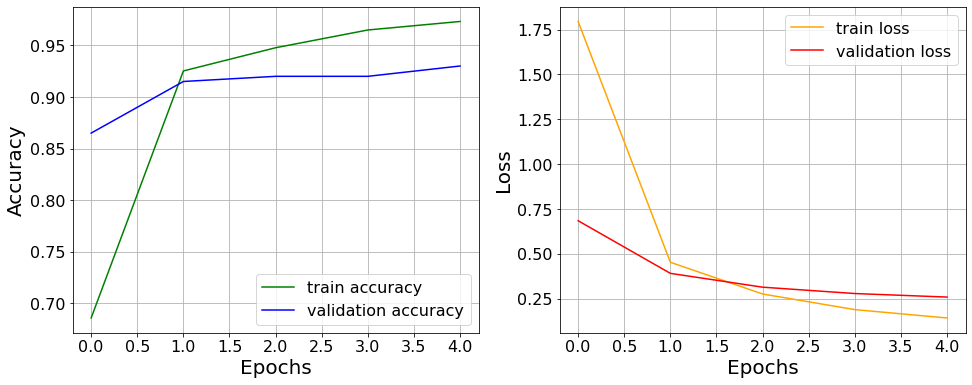

In [5]:
train_loss = model_train.history['loss']
train_acc = model_train.history['accuracy']
valid_loss = model_train.history['val_loss']
valid_acc = model_train.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validation accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validation loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results.png')

In [6]:
epoch = 15
model = tf.keras.models.load_model(filepath)

for layer in model.layers:
    layer.trainable = True

start_time2 = time.perf_counter()
model_finetune = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch,
    callbacks = [checkpoint])

print(time.perf_counter()-start_time2)

Epoch 1/15
178/178 [==============================] - 48s 248ms/step - loss: 0.2778 - accuracy: 0.9414 - val_loss: 0.3007 - val_accuracy: 0.9300

Epoch 00001: val_loss did not improve from 0.25943
Epoch 2/15
178/178 [==============================] - 42s 234ms/step - loss: 0.2284 - accuracy: 0.9498 - val_loss: 0.2903 - val_accuracy: 0.9100

Epoch 00002: val_loss did not improve from 0.25943
Epoch 3/15
178/178 [==============================] - 42s 238ms/step - loss: 0.1842 - accuracy: 0.9617 - val_loss: 0.2634 - val_accuracy: 0.9250

Epoch 00003: val_loss did not improve from 0.25943
Epoch 4/15
178/178 [==============================] - 41s 231ms/step - loss: 0.1781 - accuracy: 0.9623 - val_loss: 0.2618 - val_accuracy: 0.9200

Epoch 00004: val_loss did not improve from 0.25943
Epoch 5/15
178/178 [==============================] - 42s 233ms/step - loss: 0.1368 - accuracy: 0.9707 - val_loss: 0.2648 - val_accuracy: 0.9150

Epoch 00005: val_loss did not improve from 0.25943
Epoch 6/15
178/

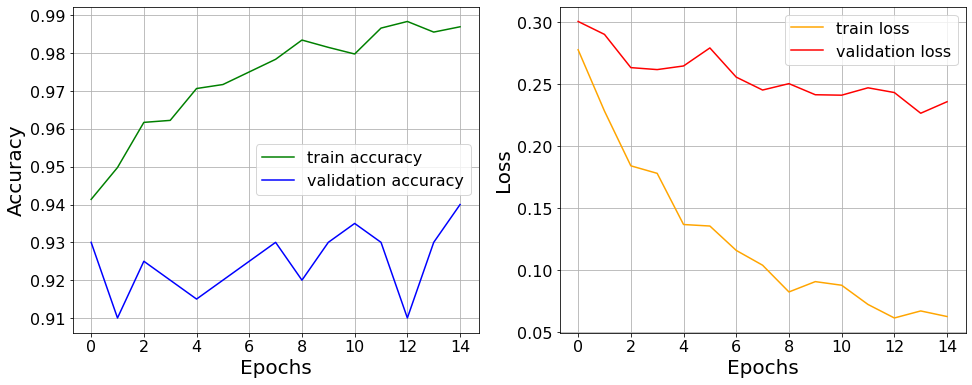

In [7]:
train_loss = model_finetune.history['loss']
train_acc = model_finetune.history['accuracy']
valid_loss = model_finetune.history['val_loss']
valid_acc = model_finetune.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validation accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validation loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results_ft.png')